In [1]:
import numpy as np
import torch
from utility import predict_func_2input_2out, load_best_model
from smalltransformer_w_sigma import SmallTransformer
from linear_process import preprocess_pro
from utility import cal_flux, predict_spectra
from sklearn.metrics import r2_score, mean_squared_error
import pickle
from sklearn.cluster import KMeans

In [2]:
# Model
batch_size = 1
model = SmallTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# model, optimizer, best_val_loss, target_min, target_max = load_best_model(
#     model, optimizer,
#     '/kaggle/input/noisereduction/pytorch/default/1/best_model_NR_v2.0.pth')
model, optimizer, best_val_loss, target_min, target_max = load_best_model(
    model, optimizer, '/kaggle/best_model_STws_v3.4.pth')

Best model loaded.


In [3]:
# 特征
with open('/kaggle/input/train_preprocessed.pkl', 'rb') as file:
    full_predictions_spectra = pickle.load(file)
full_whitelight_s_train = np.array([
    predict_spectra(full_predictions_spectra[i])
    for i in range(len(full_predictions_spectra))
])  # 预测每个星球的白光缩放比例S
full_light_alpha_train = np.array([
    cal_flux(full_predictions_spectra[i])
    for i in range(len(full_predictions_spectra))
])  # 计算每个星球的各个波段的吸收峰相对面积

In [4]:
# 目标
train_solution = np.loadtxt(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    delimiter=',',
    skiprows=1)
targets = train_solution[:, 1:]
newtarget = targets / full_whitelight_s_train[:, np.newaxis]
targets_tensor = torch.tensor(newtarget).float()
target_min = targets_tensor.min()
target_max = targets_tensor.max()
full_targets_normalized = (targets_tensor - target_min) / (target_max -
                                                           target_min)

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# # 使用 t-SNE 将数据降维到二维
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(full_targets_normalized)

# # 绘制二维平面上的数据点
# plt.figure(figsize=(10, 8))
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
# plt.title("t-SNE of full_targets_normalized")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.grid(True)
# plt.show()

In [6]:
# 使用 K-means 聚类
n_clusters = 16  # 你可以根据需要调整聚类数量
kmeans = KMeans(n_clusters=n_clusters,
                random_state=42).fit(full_targets_normalized)
cluster_labels = kmeans.labels_

c:\veighna_studio\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
np.random.seed(21)
# 初始化存储采样的索引列表
sampled_indices = []
samples_per_cluster = 640 // n_clusters  # 每个聚类中目标样本数量

for cluster in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster)[0]

    # 如果样本数量不足，则进行上采样
    if len(cluster_indices) < samples_per_cluster:
        temp_samples = cluster_indices.tolist()
        sampled_indices.extend(temp_samples)
        remaining_samples = samples_per_cluster - len(cluster_indices)
        sampled_indices.extend(
            np.random.choice(cluster_indices, remaining_samples, replace=True))
    else:
        # 样本数量充足时正常采样
        sampled_indices.extend(
            np.random.choice(cluster_indices,
                             samples_per_cluster,
                             replace=False))

print(f"Sampled indices: {len(sampled_indices)}")

Sampled indices: 640


In [8]:
mask = np.ones(full_predictions_spectra.shape[0], dtype=bool)
mask[sampled_indices] = False
predictions_spectra_test = full_predictions_spectra[mask]
min_values = predictions_spectra_test.min(axis=(1, 2), keepdims=True)
max_values = predictions_spectra_test.max(axis=(1, 2), keepdims=True)
normalized_spectra = (predictions_spectra_test - min_values) / (max_values -
                                                                min_values)
data_test_reshaped = torch.tensor(normalized_spectra).float()

In [9]:
predictions_spectra_test.shape

(340, 187, 283)

In [10]:
whitelight_s_test = full_whitelight_s_train[mask]
light_alpha_test = full_light_alpha_train[mask]
whitelight_s_train_expanded = np.expand_dims(full_whitelight_s_train[mask] *
                                             100,
                                             axis=1)
combined_array = np.concatenate(
    (light_alpha_test, whitelight_s_train_expanded), axis=1)
light_alpha_test = torch.tensor(combined_array).float()

In [11]:
mean_predictions, sigma_predictions = predict_func_2input_2out(
    model, data_test_reshaped, light_alpha_test, batch_size=1)
mean_predictions = mean_predictions * (target_max - target_min) + target_min
mean_predictions = mean_predictions.numpy()
sigma_predictions = sigma_predictions * (target_max - target_min)
sigma_predictions = sigma_predictions.numpy()

In [12]:
all_predictions = mean_predictions

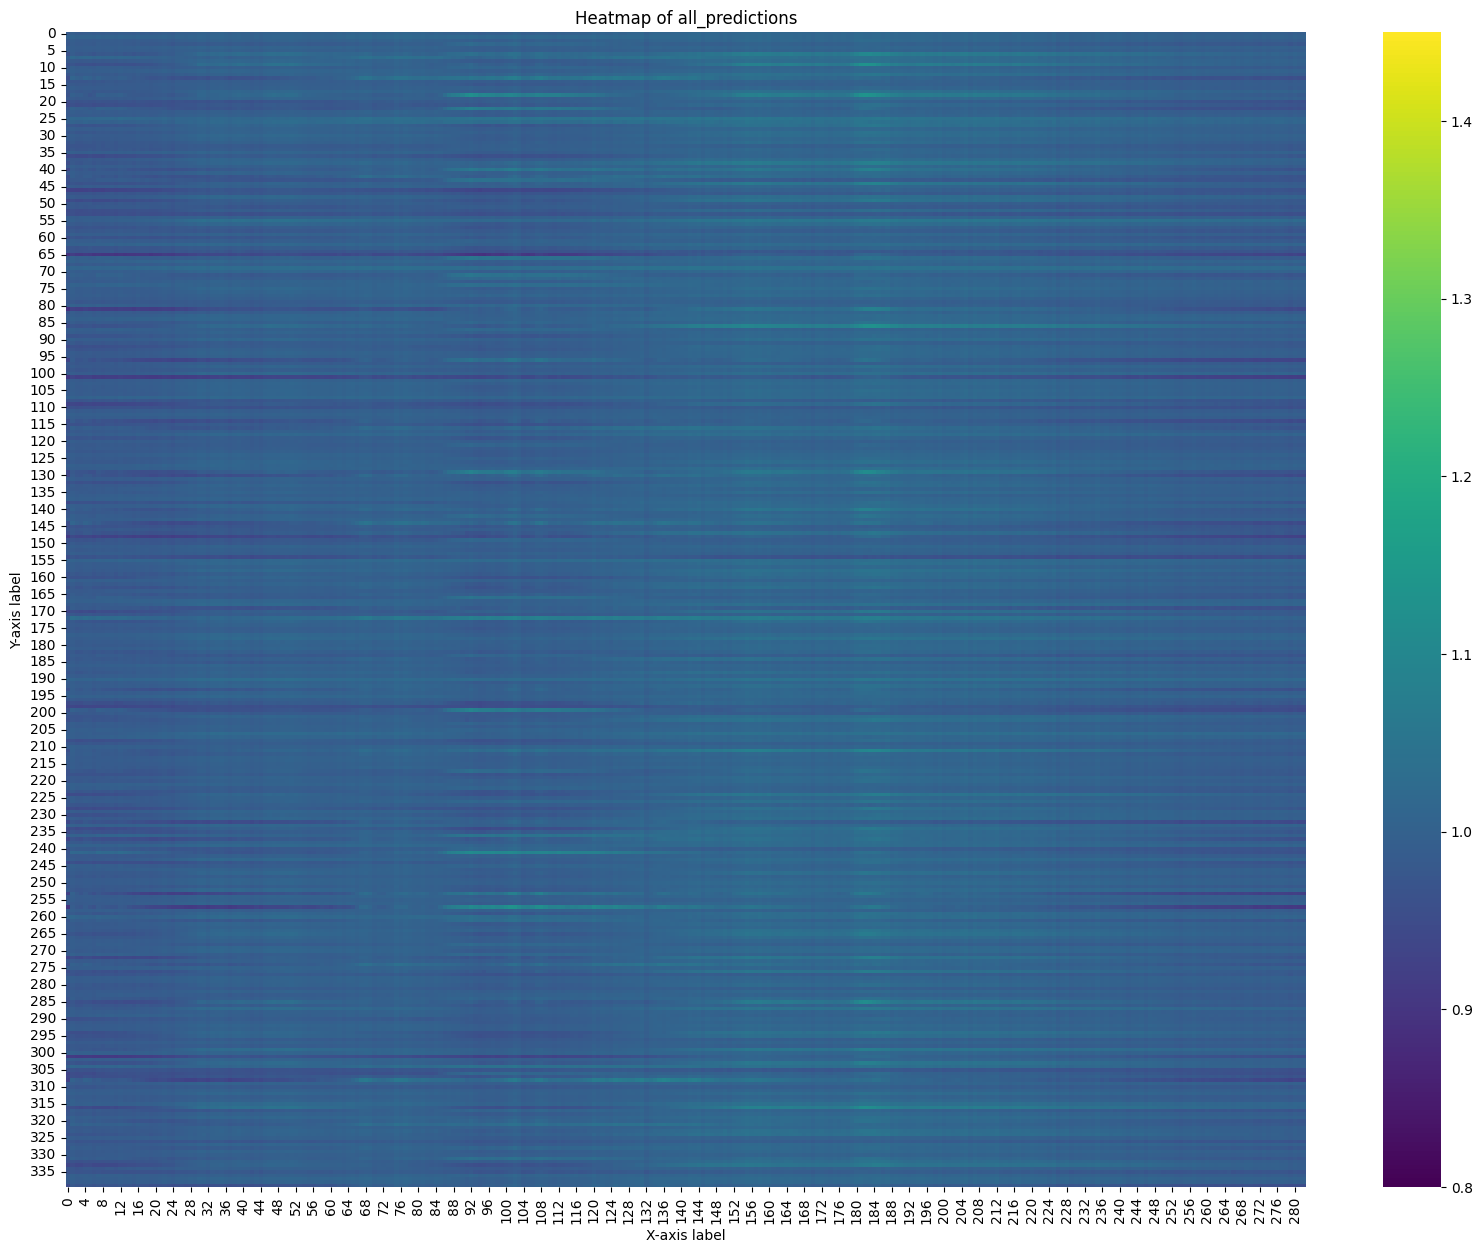

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(all_predictions,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of all_predictions")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [14]:
from utility import postprocessing, competition_score
import pandas as pd

wavelengths = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/wavelengths.csv')
test_adc_info = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
    index_col='planet_id')
train_labels = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    index_col='planet_id')

In [15]:
reviewtarget = targets[mask] / whitelight_s_test[:, np.newaxis]

In [16]:
reviewtarget.min(), reviewtarget.max()

(0.8628884048867576, 1.1572385936634801)

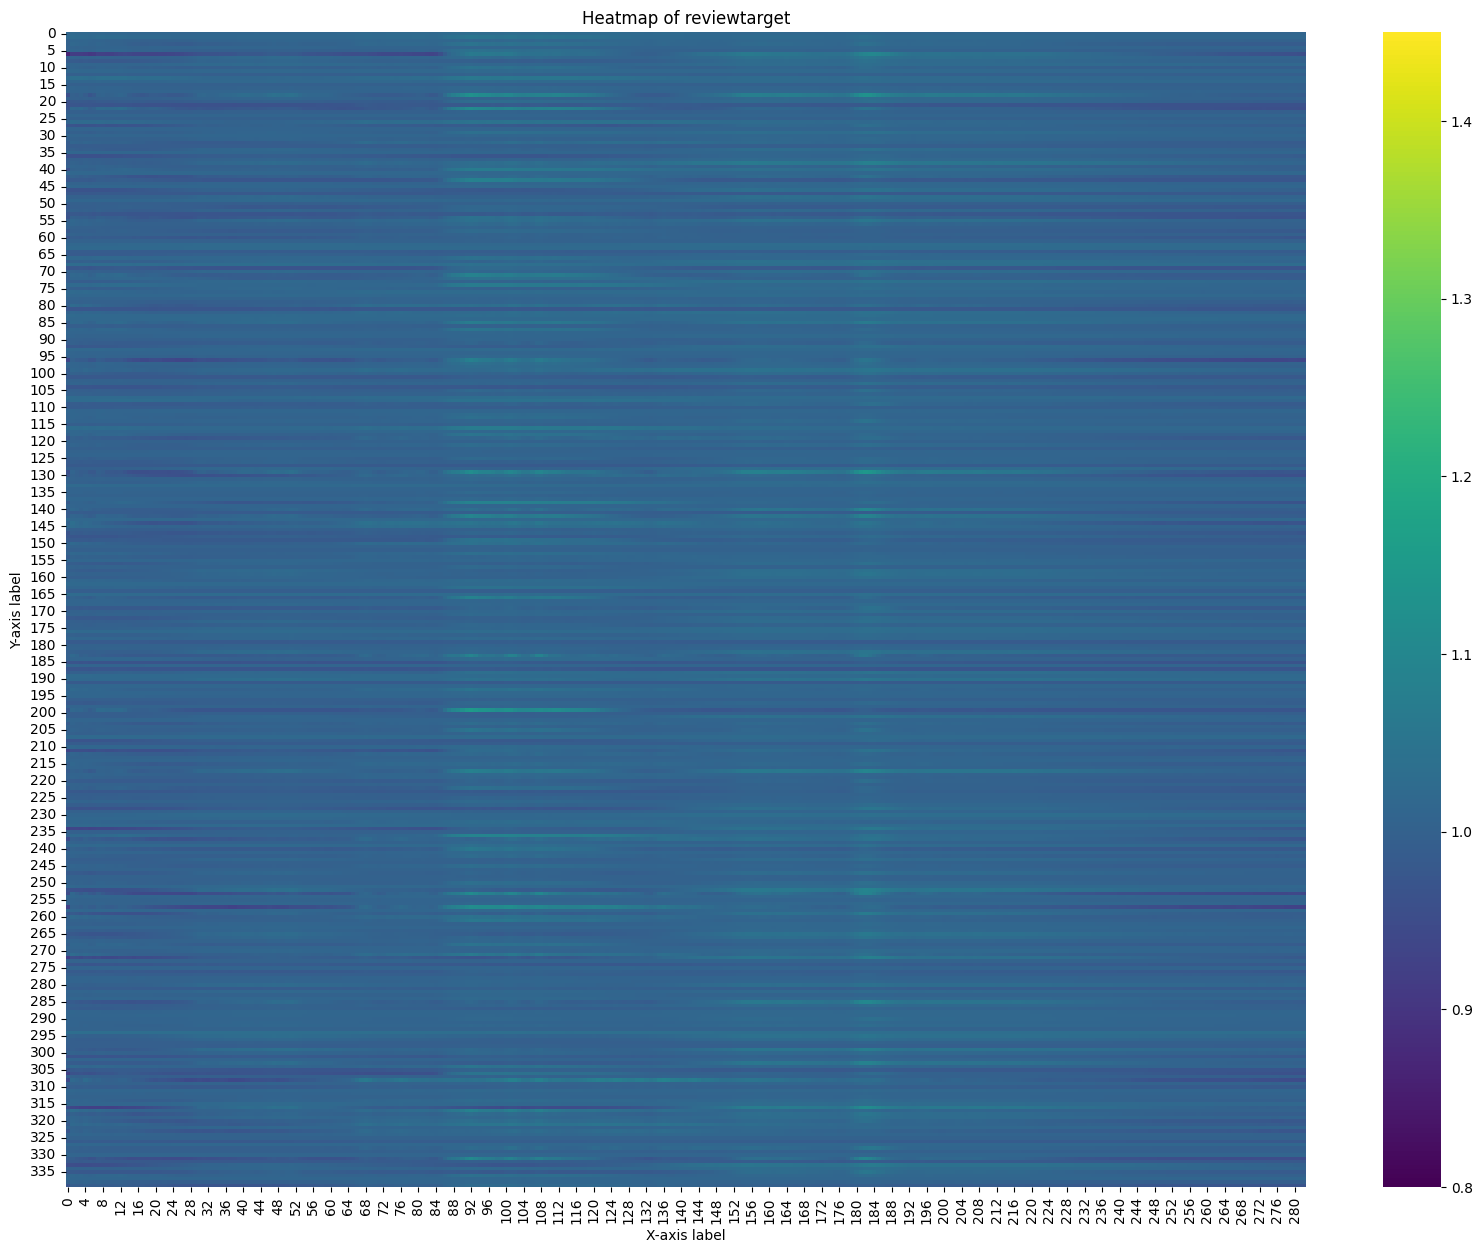

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(reviewtarget,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of reviewtarget")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [18]:
reviewtarget.min(), reviewtarget.max()

(0.8628884048867576, 1.1572385936634801)

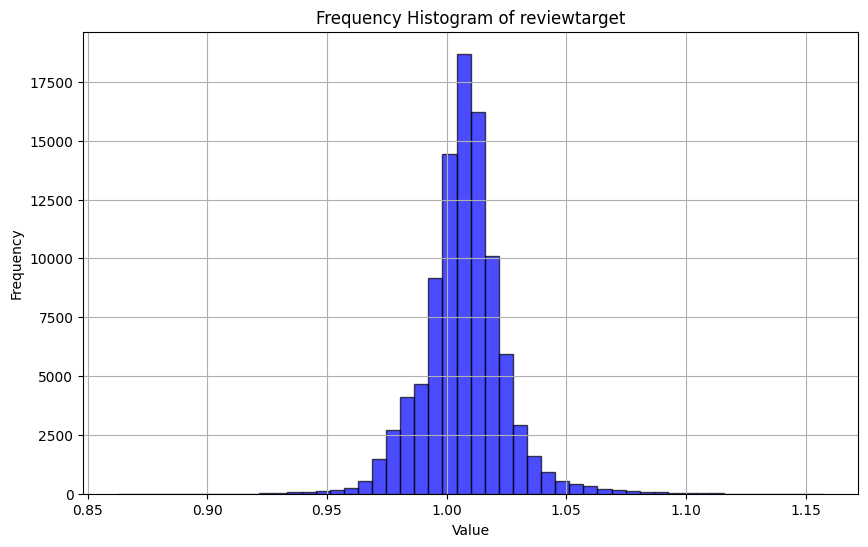

In [19]:
reviewtarget_flat = reviewtarget.flatten()
plt.figure(figsize=(10, 6))
plt.hist(reviewtarget_flat,
         bins=50,
         color='blue',
         edgecolor='black',
         alpha=0.7)
plt.title("Frequency Histogram of reviewtarget")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [20]:
all_predictions = all_predictions * whitelight_s_test[:, np.newaxis]
newsigma = sigma_predictions * whitelight_s_test[:, np.newaxis]

In [21]:
targets = targets[mask]

In [22]:
print(f"# R2 score: {r2_score(targets, all_predictions):.6f}")
sigma_pred = mean_squared_error(targets, all_predictions, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.999230
# Root mean squared error: 0.000046


In [23]:
sub_df = postprocessing(all_predictions,
                        wavelengths,
                        test_adc_info[mask].index,
                        sigma_pred=newsigma)

In [24]:
# sub_df = postprocessing(all_predictions,
#                         wavelengths,
#                         test_adc_info[mask].index,
#                         sigma_pred=np.tile(
#                             np.where(test_adc_info[mask][['star']] <= 1,
#                                      0.000046, 0.000046), (1, 283)))

In [25]:
gll_score = competition_score(train_labels[mask].copy().reset_index(),
                              sub_df.copy().reset_index(),
                              naive_mean=train_labels[mask].values.mean(),
                              naive_sigma=train_labels[mask].values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.6}")

# Estimated competition score: 0.632415


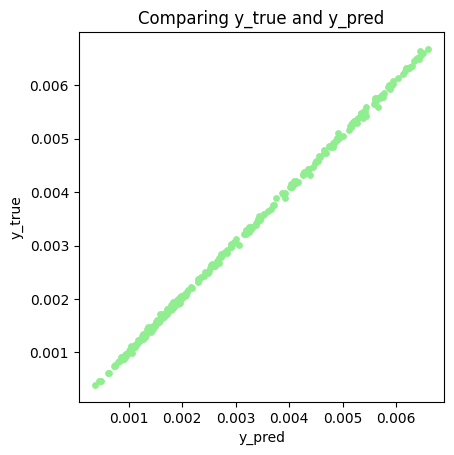

In [26]:
import matplotlib.pyplot as plt

col = 1
plt.scatter(all_predictions[:, col], targets[:, col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

Outlier lens: 7
Outliers: (array([  6,  49,  65, 145, 198, 294, 301], dtype=int64),)


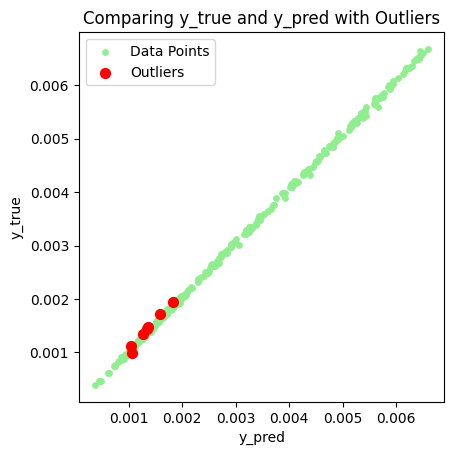

In [27]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

col = 1
# 假设 predict_targets 和 targets 是 numpy 数组
errors = np.abs(all_predictions[:, col] - targets[:, col])
outliers = np.where(errors > newsigma[:, col] * 2)

# 打印异常值索引
print("Outlier lens:", len(outliers[0]))
print("Outliers:", outliers)
plt.scatter(all_predictions[:, col],
            targets[:, col],
            s=15,
            c='lightgreen',
            label='Data Points')
plt.scatter(all_predictions[outliers[0], col],
            targets[outliers[0], col],
            s=50,
            c='red',
            label='Outliers')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred with Outliers')
plt.legend()
plt.show()

In [28]:
import numpy as np
from scipy import stats
from collections import Counter, defaultdict

# 假设 predict_targets 和 targets 是 numpy 数组
num_cols = all_predictions.shape[1]
threshold = 1
outlier_counts = Counter()
normal_columns = defaultdict(list)

for col in range(num_cols):
    errors = np.abs(all_predictions[:, col] - targets[:, col])
    outliers = np.where(errors > newsigma[:, col] * threshold)[0]
    normals = np.where(errors <= newsigma[:, col] * threshold)[0]

    # 统计每个异常点的频次
    outlier_counts.update(outliers)

    # 记录每个数据点在哪些列中是正常的
    for normal in normals:
        normal_columns[normal].append(col)

# 按频次排序
sorted_outliers = outlier_counts.most_common()

# 打印每个异常点的频次及其正常的列
for outlier, count in sorted_outliers:
    normal_cols = normal_columns[outlier]
    print(
        f"Data point {outlier} is an outlier in {count} columns and normal in columns: {normal_cols}"
    )

Data point 46 is an outlier in 282 columns and normal in columns: [187]
Data point 99 is an outlier in 281 columns and normal in columns: [0, 28]
Data point 108 is an outlier in 280 columns and normal in columns: [75, 158, 160]
Data point 145 is an outlier in 278 columns and normal in columns: [131, 135, 143, 144, 146]
Data point 65 is an outlier in 264 columns and normal in columns: [154, 155, 156, 157, 158, 159, 160, 163, 164, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189]
Data point 68 is an outlier in 249 columns and normal in columns: [69, 75, 77, 131, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 154, 155, 158, 160, 172, 185, 187, 188, 189, 191, 194, 195, 197, 212]
Data point 198 is an outlier in 249 columns and normal in columns: [144, 146, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 163, 165, 167, 172, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 194, 197, 199, 205, 212]
Data point 69 is an outlier in 248 columns an

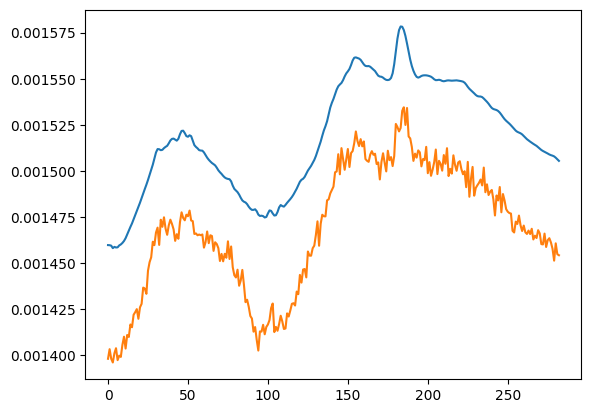

In [29]:
planet = 46
plt.plot(targets[planet, :])
plt.plot(all_predictions[planet, :])